## Import Resources

In [1]:
import matplotlib.pyplot as plt
plt.style.use('seaborn')
import numpy as np
import pandas as pd
import scipy.stats as stats
import seaborn as sns
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.tools.eval_measures import rmse
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.linear_model import LinearRegression
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.ticker as ticker
import math

## Process Data

The function below reads and cleans the data, removes some extreme outliers, and adds a few features that we were interested in exploring for our analysis. For full documentation, see 'functions.py'.

In [2]:
import functions as fn

df = fn.import_and_clean_data('../data/kc_house_data.csv')
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,greenbelt,...,sqft_patio,yr_built,yr_renovated,address,lat,long,age,state,bath_to_bed,zip
0,7399300360,5/24/2022,675000.0,4,1.0,1180,7140,1.0,NO,NO,...,40,1969,0,"2102 Southeast 21st Court, Renton, Washington ...",47.461975,-122.190520,52,Washington,0.250000,98055
1,8910500230,12/13/2021,920000.0,5,2.5,2770,6703,1.0,NO,NO,...,240,1950,0,"11231 Greenwood Avenue North, Seattle, Washing...",47.711525,-122.355910,71,Washington,0.500000,98133
2,1180000275,9/29/2021,311000.0,6,2.0,2880,6156,1.0,NO,NO,...,0,1956,0,"8504 South 113th Street, Seattle, Washington 9...",47.502045,-122.225200,65,Washington,0.333333,98178
5,2807100156,7/20/2021,625000.0,2,1.0,1190,5688,1.0,NO,NO,...,0,1948,0,"1602 North 185th Street, Shoreline, Washington...",47.763470,-122.340155,73,Washington,0.500000,98133
6,5122400111,11/17/2021,1317227.0,3,3.0,2080,27574,1.0,NO,NO,...,150,1951,0,"2633 Southwest 164th Place, Burien, Washington...",47.455470,-122.367220,70,Washington,1.000000,98166


## Data Exploration

<AxesSubplot:ylabel='Frequency'>

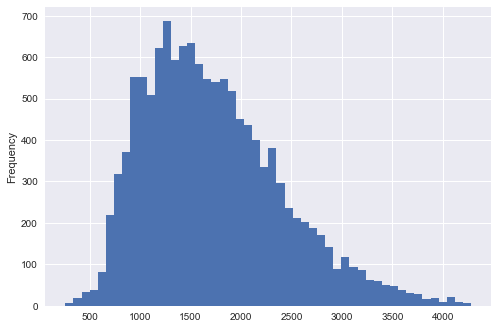

In [3]:
# Distribution of living space
df['sqft_living'].plot(kind = 'hist', bins = 50)

The distribution for the living space in square feet looks to be mostly normal. This will likely be a strong include in our future model.

<AxesSubplot:ylabel='Frequency'>

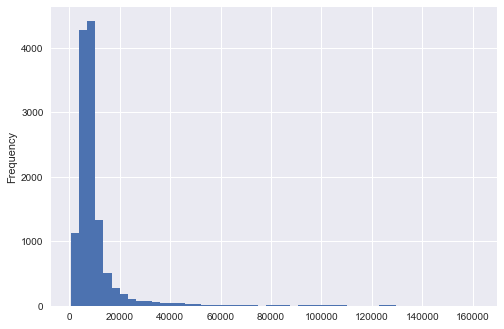

In [4]:
# Distribution of lot size
df['sqft_lot'].plot(kind = 'hist', bins = 50)

Even after removing outliers, this feature is still extremely right-skewed. Our stakeholder cannot change the lot size through renovation, but this could be a confounding variable in our analysis.

<AxesSubplot:ylabel='Frequency'>

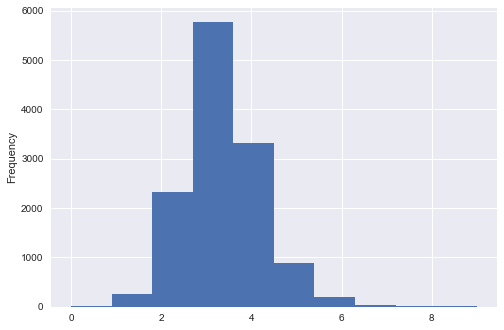

In [5]:
# Distribution of bedrooms
df['bedrooms'].plot(kind = 'hist', bins = 10)

Shows a distribution that is close to normal. Might be a good candidate for predicting the price.

<AxesSubplot:ylabel='Frequency'>

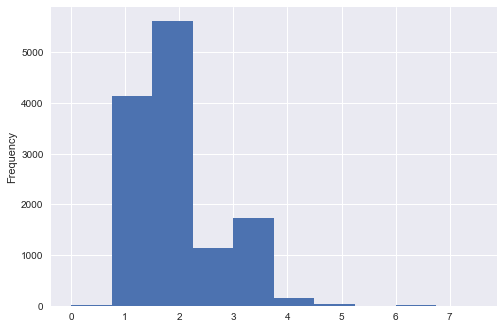

In [6]:
# Distribution of bathrooms
df['bathrooms'].plot(kind = 'hist', bins = 10)

Compared to bedrooms, the distribution of bathrooms seems less normally-distributed. Most homes have 2 bathrooms, but there is a curious spike at 3. A future consideration might be to fit the bathrooms into a different kind of model.

<AxesSubplot:ylabel='Frequency'>

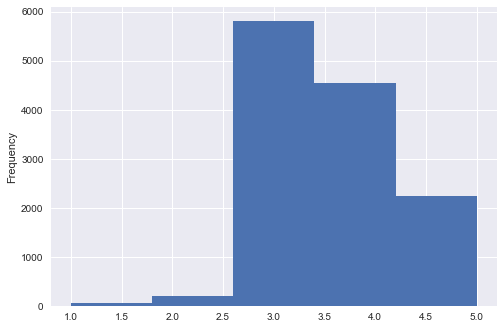

In [7]:
# Distribution of home condition
df['condition'].plot(kind = 'hist', bins = 5)

Most of the data in this feature lies between 3 and 5, which makes sense since a home condition below 3 is considered in disrepair. Not very normally distributed.

<AxesSubplot:ylabel='Frequency'>

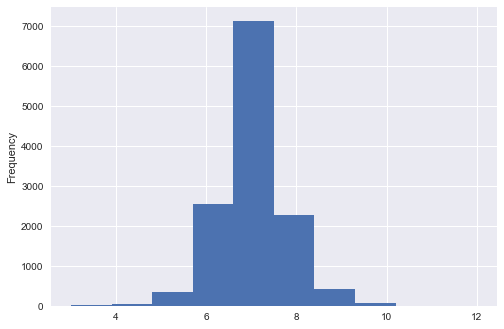

In [8]:
# Distribution of home grade
df['grade'].plot(kind = 'hist', bins = 10)

Compared with condition, the grade is much more normally distributed, with most of the homes having a grade value of 7, or "average condition". Grade might be a better explanatory variable than condition.

(array([-500000.,       0.,  500000., 1000000., 1500000., 2000000.,
        2500000., 3000000., 3500000., 4000000.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

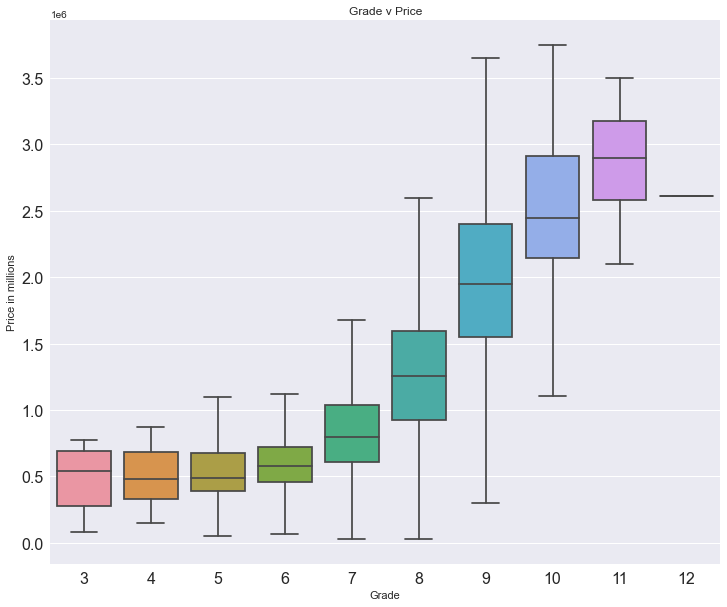

In [9]:
# Plotting home grade versus the price
fig, ax = plt.subplots(figsize = (12,10))
ax = sns.boxplot(x = df['grade'], y = df['price'], showfliers = False)
ax.set_title("Grade v Price");
ax.set_ylabel("Price in millions")
ax.set_xlabel('Grade')
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)

When compared with price, the grade of a home displays some exponential qualities. Improving from lower grades confers almost no increase in value, while improving a higher-grade home increases the value more and more as you move up the scale. We could consider a different modeling schema for this variable in the future.

<AxesSubplot:ylabel='Frequency'>

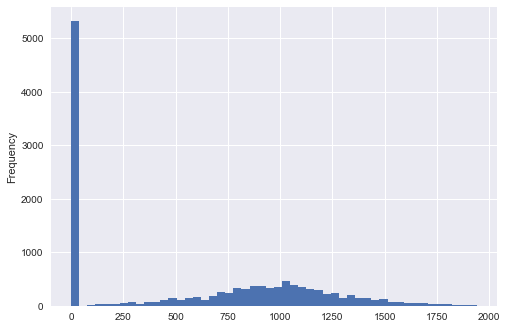

In [10]:
# Distribution of basement size
df['sqft_basement'].plot(kind = 'hist', bins = 50)

The middle of the basement data set is somewhat normally-distributed, but many of the homes in the data set have no basement at all, likely because they are located in the densely-populated area where a basement is not feasible to build. If we were to examine basement size's effect more closely, we might want to create a separate model that disincludes the houses with no basement compatibility.

<AxesSubplot:ylabel='Frequency'>

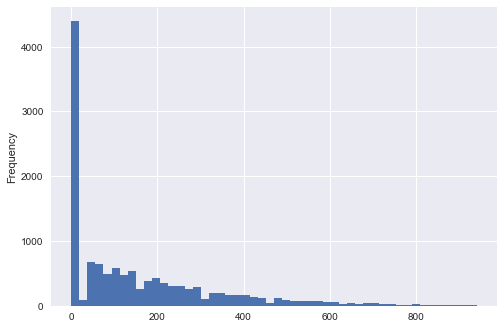

In [11]:
# Distribution of patio size
df['sqft_patio'].plot(kind = 'hist', bins = 50)

Like with basement size, many of the homes in the data set do not have a patio. The data is also right-skewed, with most homes with patios having smaller patios.

<AxesSubplot:ylabel='Frequency'>

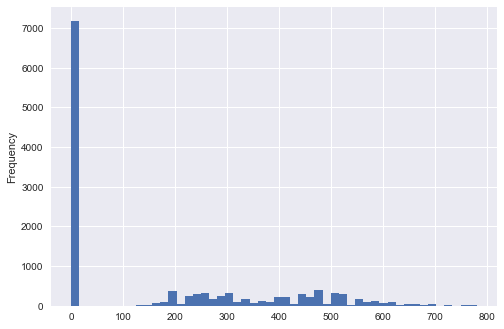

In [12]:
# Distribution of garage size
df['sqft_garage'].plot(kind = 'hist', bins = 50)

Again, many of the homes in the data set do not have garages. Curiously, there appear to be two peaks in the data for homes with garages around 250 square feet and 500 square feet. This could be most garages falling into a standardized "one car" or "two car" template.

## Profitability of Renovation

Of interest to our stakeholder is the amount we could expect to earn from renovating a home. We can determine this baseline by comparing the prices of homes with and without remodels.

In [13]:
# Create a feature for renovated vs. non-renovated homes
df_reno = df.copy()
df_reno['Renovation'] = df_reno['yr_renovated'].apply(lambda x: 1 if x > 0 else 0)


805000.0
202000.0


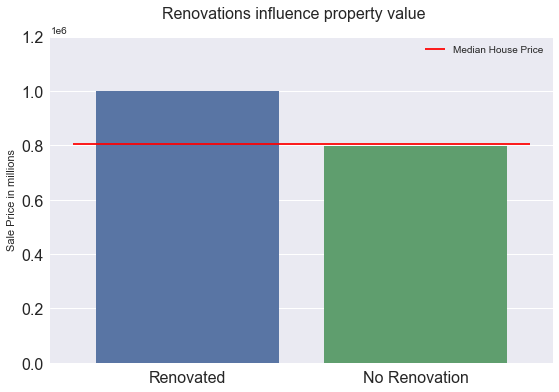

In [14]:
# Separate data into renovated or not renovated and find the median
renovated = df_reno[(df_reno["Renovation"] == 1)]
renovated_median = renovated.price.median()
no_renovation = df_reno[(df_reno["Renovation"] == 0)]
no_renovation_median = no_renovation.price.median()

label_renovation = ["Renovated", "No Renovation"]
values_renovation = [renovated_median, no_renovation_median]

# Plot the median prices of the two subgroups
fig, ax = plt.subplots( figsize=(9,6))
sns.barplot(ax=ax, x=label_renovation, y=values_renovation )
plt.suptitle("Renovations influence property value", size=16, y=.95)
ax.hlines(df_reno['price'].median(), -.5 ,1.5, colors="red", label="Median House Price")

# Create a line at the median for all homes in the data set
ax.set_ylim(0,1.2*renovated_median)

ax.legend()
ax.set_ylabel("Sale Price in millions")
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
print(df_reno['price'].median())
# print(no_renovation_median)
print(renovated_median - no_renovation_median)

Clearly, renovation does indeed add value to the home. Comparing the difference between the two medians, we could expect to earn around $200,000 for renovating a home in this area.

## Model Exploration

In [15]:
# Remove variables that cannot be renovated or are not necessary for analysis
df = df.drop(['id', 'date', 'sqft_lot', 'sqft_above', 'floors', 'yr_built', 'yr_renovated', 
              'lat', 'long', 'waterfront', 'greenbelt', 'nuisance', 'view', 'heat_source', 
              'sewer_system', 'address', 'age', 'state', 'zip'], axis=1)
df.head()

,price,bedrooms,bathrooms,sqft_living,condition,grade,sqft_basement,sqft_garage,sqft_patio,bath_to_bed
0,675000.0,4,1.0,1180,4,7,0,0,40,0.250000
1,920000.0,5,2.5,2770,3,7,1570,0,240,0.500000
2,311000.0,6,2.0,2880,3,7,1580,0,0,0.333333
5,625000.0,2,1.0,1190,3,7,0,300,0,0.500000
6,1317227.0,3,3.0,2080,4,9,0,0,150,1.000000


In [16]:
# Create correlation matrix
df.corr()

,price,bedrooms,bathrooms,sqft_living,condition,grade,sqft_basement,sqft_garage,sqft_patio,bath_to_bed
price,1.000000,0.283312,0.474756,0.552702,0.108144,0.566275,0.341234,0.089480,0.237373,0.270852
bedrooms,0.283312,1.000000,0.577259,0.648893,0.102478,0.389889,0.343126,0.168299,0.178665,-0.226574
bathrooms,0.474756,0.577259,1.000000,0.752647,0.188031,0.537416,0.417789,0.225588,0.301255,0.605769
sqft_living,0.552702,0.648893,0.752647,1.000000,0.115462,0.641682,0.571922,0.183282,0.349607,0.271819
condition,0.108144,0.102478,0.188031,0.115462,1.000000,0.069514,-0.012314,0.052330,0.093269,0.106581
grade,0.566275,0.389889,0.537416,0.641682,0.069514,1.000000,0.366947,0.289663,0.256443,0.232082
sqft_basement,0.341234,0.343126,0.417789,0.571922,-0.012314,0.366947,1.000000,0.098477,0.212417,0.178167
sqft_garage,0.089480,0.168299,0.225588,0.183282,0.052330,0.289663,0.098477,1.000000,0.103377,0.084024
sqft_patio,0.237373,0.178665,0.301255,0.349607,0.093269,0.256443,0.212417,0.103377,1.000000,0.180827
bath_to_bed,0.270852,-0.226574,0.605769,0.271819,0.106581,0.232082,0.178167,0.084024,0.180827,1.000000


<AxesSubplot:>

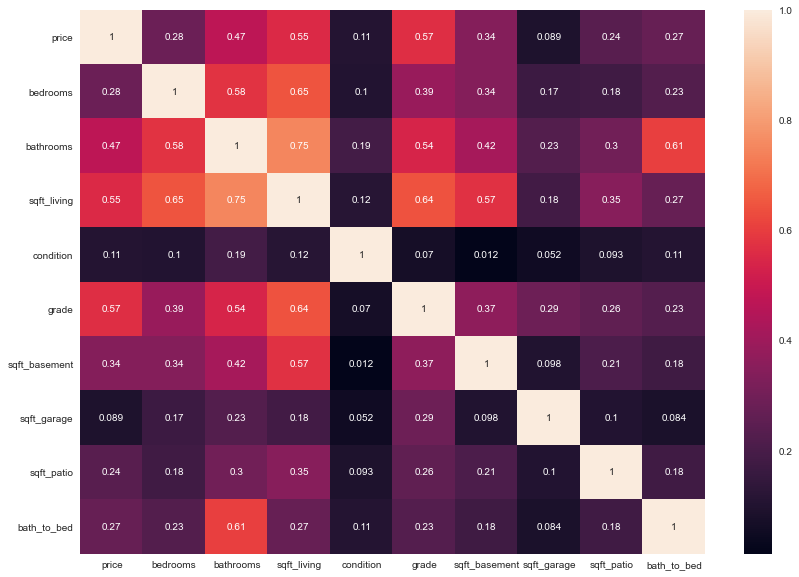

In [17]:
# Visualize the correlations in a heatmap
fig, ax = plt.subplots(figsize=(14,10))
sns.heatmap(df.corr().abs(), annot=True)

Looking at the heatmap, a the number of bathrooms and the square feet of the living space could be considered strongly colinear (> 0.7). Interestingly, the condition and grade of the house do not seem to be highly correlated with one another.

## Baseline Model

To use as a baseline, we've created a dummy model that makes predictions based only on the mean of the data set.

In [18]:
# Set target and predictor
X = df.drop(['price'], axis=1)
y = df['price']

# Initialize dummy regressor and fit the the data
dummy_regr = DummyRegressor(strategy="mean")
reg = dummy_regr.fit(X, y)

In [19]:
# Generate predictions based on dummy model
y_hat = reg.predict(X)
y_hat

array([934314.97677681, 934314.97677681, 934314.97677681, ...,
       934314.97677681, 934314.97677681, 934314.97677681])

In [20]:
# Print scores
print(f'Baseline Model RMSE: {math.sqrt(mean_squared_error(y, y_hat))}')
print(f'Baseline Model Score: {(dummy_regr.score(X, y))}')

Baseline Model RMSE: 521371.72509410046
Baseline Model Score: 0.0


With an R-squared of 0, there is much room for improvement. We will keep the root mean squared error of 521371 in mind when evaluating our future models.

## Simple Model

In [21]:
# Establish target and predictors
target = df['price']
predictors = df['sqft_living']

# Add a constant
predictors = sm.add_constant(predictors)

# Generate model
model = sm.OLS(target, predictors).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.305
Model:                            OLS   Adj. R-squared:                  0.305
Method:                 Least Squares   F-statistic:                     5643.
Date:                Fri, 16 Sep 2022   Prob (F-statistic):               0.00
Time:                        11:23:49   Log-Likelihood:            -1.8479e+05
No. Observations:               12832   AIC:                         3.696e+05
Df Residuals:                   12830   BIC:                         3.696e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const        2.063e+05   1.04e+04     19.794      0.000    1.86e+05    2.27e+05
sqft_living   421.7780      5.615     75.121      0.000     410.772     432.784
==============================================================================
Omnibus:                     3726.927   Durbin-Watson:                   1.970
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            15924.786
Skew:                           1.371   Prob(JB):                         0.00
Kurtosis:                       7.719   Cond. No.                     5.04e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.04e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [22]:
# Generate model predictions and RMSE
y_hat = model.predict(predictors)
print(f'Simple Model RMSE: {math.sqrt(mean_squared_error(target, y_hat))}')

Simple Model RMSE: 434500.2199594628


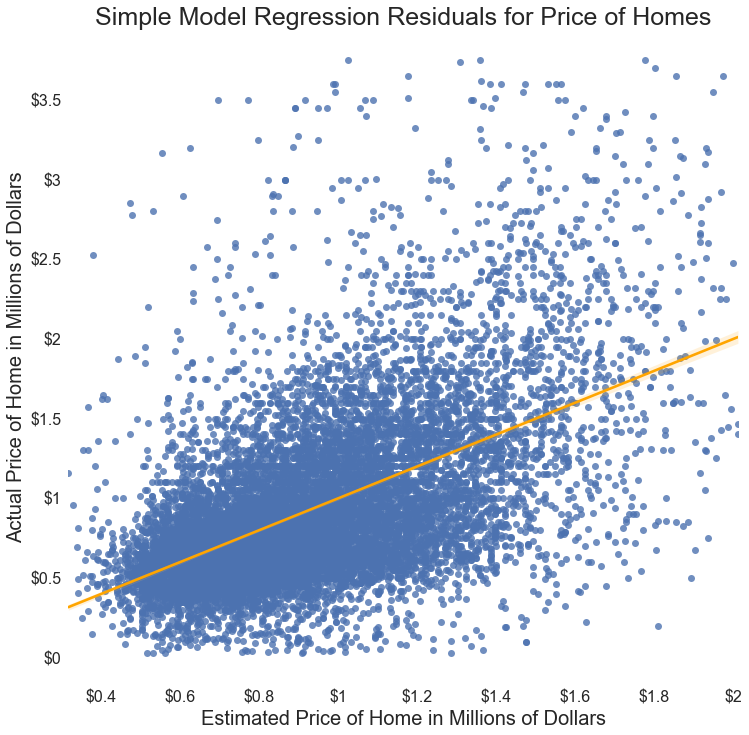

In [23]:
# Plot first model's predictions against the actual home prices
sns.set_style(style='white')
fig, ax = plt.subplots(figsize = (12,12))
sns.regplot(x = y_hat, y = target, line_kws={"color": "orange"})
ax.set_title('Simple Model Regression Residuals for Price of Homes', fontsize = 25)
ax.set_xlabel('Estimated Price of Home in Millions of Dollars', fontsize = 20)
ax.set_ylabel('Actual Price of Home in Millions of Dollars', fontsize = 20)

#Scale axes
millions = ticker.FuncFormatter(lambda x, pos: '${0:g}'.format(x/1000000))
ax.yaxis.set_major_formatter(millions)
ax.xaxis.set_major_formatter(millions)

plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
plt.show()

This model is very simple, using only the square feet of the lviing area to predict the house's price. The R-squared value has increased to .305, meaning this model can explain around 31% of the variation in home price. In addition, the RMSE has been reduced to 434500, which is a definite improvement over the dummy model.

## Model Two

Expanding the living area of the home is not the only feature our stakeholder would be interested in. In our second model, we included every potential factor that could reasonably be modified through renovation. Because the distributions for bedrooms and bathrooms seemed to follow a curious pattern, we decided to include the ratio of bathrooms to bedrooms to determine if that could provide some explanation.

In [24]:
# Establish target and predictors
target = df['price']
predictors = df.drop(['price'], axis=1)

# Add a constant
predictors = sm.add_constant(predictors)

# Generate model
model = sm.OLS(target, predictors).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.404
Model:                            OLS   Adj. R-squared:                  0.404
Method:                 Least Squares   F-statistic:                     967.2
Date:                Fri, 16 Sep 2022   Prob (F-statistic):               0.00
Time:                        11:23:49   Log-Likelihood:            -1.8381e+05
No. Observations:               12832   AIC:                         3.676e+05
Df Residuals:                   12822   BIC:                         3.677e+05
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const         -1.044e+06   4.91e+04    -21.255      0.000   -1.14e+06   -9.48e+05
bedrooms      -7.015e+04   9718.219     -7.218      0.000   -8.92e+04   -5.11e+04
bathrooms      9.163e+04   1.58e+04      5.784      0.000    6.06e+04    1.23e+05
sqft_living     218.3936     10.437     20.925      0.000     197.936     238.852
condition      2.764e+04   4619.382      5.984      0.000    1.86e+04    3.67e+04
grade          2.257e+05   5685.544     39.703      0.000    2.15e+05    2.37e+05
sqft_basement    36.5471      7.961      4.591      0.000      20.942      52.153
sqft_garage    -205.8078     17.508    -11.755      0.000    -240.125    -171.490
sqft_patio       72.3055     20.657      3.500      0.000      31.815     112.796
bath_to_bed    -3.21e+04   4.54e+04     -0.707      0.479   -1.21e+05    5.68e+04
==============================================================================
Omnibus:                     4211.686   Durbin-Watson:                   1.954
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            22985.437
Skew:                           1.478   Prob(JB):                         0.00
Kurtosis:                       8.853   Cond. No.                     3.50e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.5e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [25]:
# Generate predictions and RMSE
y_hat = model.predict(predictors)
print(f'Model Two RMSE: {math.sqrt(mean_squared_error(target, y_hat))}')


Model Two RMSE: 402376.8607352562


With an increased R-squared value of 0.404, more of the variation in home price is explained by the second model than the first. This model also provides an interesting view of the potential value changes by individual renovation using the coefficients of the model's predictors. According to this model, adding bedrooms and garage space appears to decrease the value of the home. Location is likely a confouding variable here, with more expensive urban homes tending to have fewer bedrooms and no garage space.

However, the condition number is high and the predictors may need to be standard scaled. Futhermore, the bath-to-bed ratio does not seem to have explained anything about the difference in distributions between those two variables.

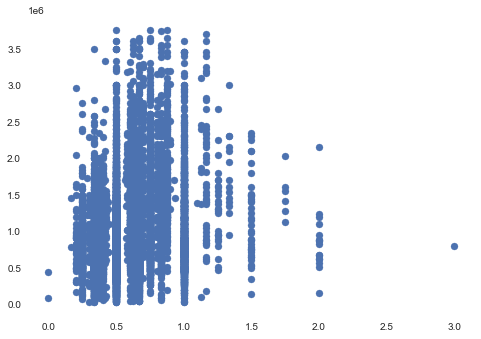

In [26]:
# Plot bathroom to bedroom ratio against home price
fig, ax = plt.subplots()
ax.scatter(df['bath_to_bed'], df['price'])

Looking at the distribution, it appears that owners highly value a bathroom to bedroom ratio around 1, with lower and higher ratios seeming to diminish the value somewhat. For our next model, we tried to generate bathroom and bedroom score by multiplying them together instead of creating a ratio. Perhaps this will better explain the value of these rooms in comparison to one another.

## Model Three

In [27]:
# Create scaled version of dataframe
df_scaled = df.copy()

# list for numeric columns to scale
cols_to_scale = ['sqft_living', 'sqft_basement', 'sqft_garage', 'sqft_patio', 'bedrooms', 'bathrooms']

# create and fit scaler
scaler = StandardScaler()
scaler.fit(df_scaled[cols_to_scale])

# scale selected data
df_scaled[cols_to_scale] = scaler.transform(df_scaled[cols_to_scale])

In [28]:
# Add a bed-bath score feature
df_scaled['bed_bath_scaled'] = df_scaled['bathrooms'] * df_scaled['bedrooms']

In [29]:
# Set target and predictors
target = df_scaled['price']
predictors = df_scaled.drop(['price', 'bath_to_bed'], axis=1)

# Add a constant
predictors = sm.add_constant(predictors)

# Generate model
model = sm.OLS(target, predictors).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.407
Model:                            OLS   Adj. R-squared:                  0.406
Method:                 Least Squares   F-statistic:                     976.5
Date:                Fri, 16 Sep 2022   Prob (F-statistic):               0.00
Time:                        11:23:50   Log-Likelihood:            -1.8378e+05
No. Observations:               12832   AIC:                         3.676e+05
Df Residuals:                   12822   BIC:                         3.677e+05
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const           -8.073e+05   4.44e+04    -18.196      0.000   -8.94e+05    -7.2e+05
bedrooms        -6.827e+04   4811.944    -14.188      0.000   -7.77e+04   -5.88e+04
bathrooms        5.335e+04   5774.862      9.239      0.000     4.2e+04    6.47e+04
sqft_living      1.497e+05   7116.047     21.041      0.000    1.36e+05    1.64e+05
condition        3.083e+04   4628.332      6.662      0.000    2.18e+04    3.99e+04
grade             2.31e+05   5698.381     40.540      0.000     2.2e+05    2.42e+05
sqft_basement    2.072e+04   4349.757      4.764      0.000    1.22e+04    2.92e+04
sqft_garage     -4.156e+04   3754.091    -11.072      0.000   -4.89e+04   -3.42e+04
sqft_patio        1.38e+04   3814.790      3.617      0.000    6322.151    2.13e+04
bed_bath_scaled  2.022e+04   2847.879      7.100      0.000    1.46e+04    2.58e+04
==============================================================================
Omnibus:                     4245.648   Durbin-Watson:                   1.952
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            23710.935
Skew:                           1.483   Prob(JB):                         0.00
Kurtosis:                       8.962   Cond. No.                         102.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [30]:
# Generate predictors and RMSE
y_hat = model.predict(predictors)
print(f'Model Three RMSE: {math.sqrt(mean_squared_error(target, y_hat))}')

Model Three RMSE: 401596.1537060746


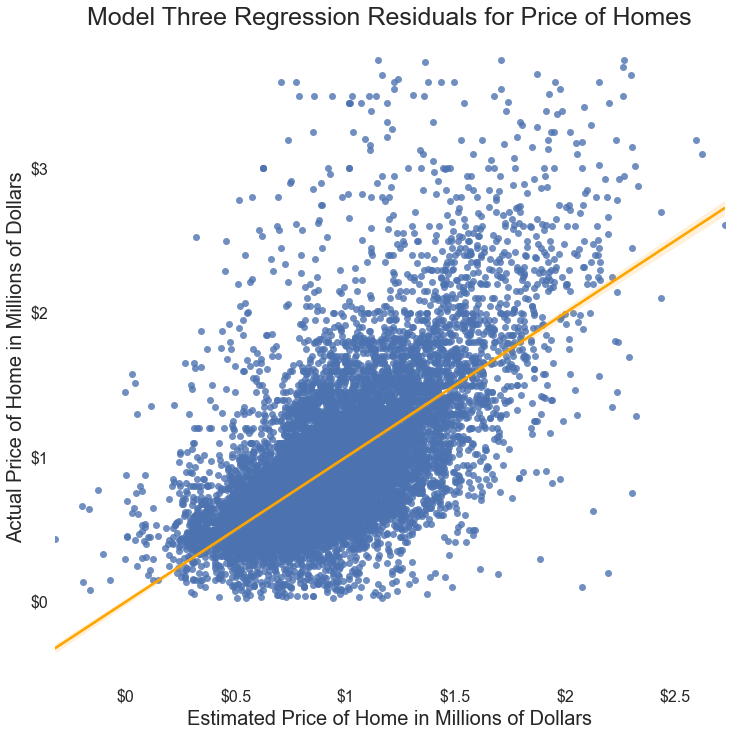

In [31]:
# Plot residuals of model 3 
sns.set_style(style='white')
fig, ax = plt.subplots(figsize = (12,12))
sns.regplot(x = y_hat, y = target, line_kws={"color": "orange"})
ax.set_title('Model Three Regression Residuals for Price of Homes', fontsize = 25)
ax.set_xlabel('Estimated Price of Home in Millions of Dollars', fontsize = 20)
ax.set_ylabel('Actual Price of Home in Millions of Dollars', fontsize = 20)

millions = ticker.FuncFormatter(lambda x, pos: '${0:g}'.format(x/1000000))
ax.yaxis.set_major_formatter(millions)
ax.xaxis.set_major_formatter(millions)

plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
plt.show()

In the third iteration of our model, we managed to improve the RMSE and condition score. Using this model's coefficients, we can provide the stakeholder an idea of which renovations generate profitable value increases in the price of a home.

In [32]:
model.params

const             -807259.693698
bedrooms           -68269.728125
bathrooms           53353.896969
sqft_living        149728.544798
condition           30833.088298
grade              231012.666724
sqft_basement       20721.590778
sqft_garage        -41563.821089
sqft_patio          13799.707146
bed_bath_scaled     20218.551223
dtype: float64

In [33]:
# Calculate the effect each unit of variables has on price, as well as de-scale the scaled variables
bed_effect = model.params[1] / df['bedrooms'].std()
bath_effect = model.params[2] / df['bathrooms'].std()
living_effect = model.params[3] / df['sqft_living'].std()
condition_effect = model.params[4]
grade_effect = model.params[5]
base_effect = model.params[6] / df['sqft_basement'].std()
garage_effect = model.params[7] / df['sqft_garage'].std()
patio_effect = model.params[8] / df['sqft_patio'].std()

In [34]:
# Print the renovation values
print(f'Adding a bedroom contributes {round(bed_effect)} dollars to the home value.')
print(f'Adding a bathroom contributes {round(bath_effect)} dollars to the home value.')
print(f'Adding 1 square foot of living area contributes {round(living_effect)} dollars to the home value.')
print(f'Increasing condition by 1 contributes {round(condition_effect)} dollars to the home value.')
print(f'Increasing grade by 1 contributes {round(grade_effect)} dollars to the home value.')
print(f'Adding 1 square foot of basement contributes {round(base_effect)} dollars to the home value.')
print(f'Adding 1 square foot of garage contributes {round(garage_effect)} dollars to the home value.')
print(f'Adding 1 square foot of patio contributes {round(patio_effect)} dollars to the home value.')

Adding a bedroom contributes -68470.0 dollars to the home value.
Adding a bathroom contributes 69211.0 dollars to the home value.
Adding 1 square foot of living area contributes 219.0 dollars to the home value.
Increasing condition by 1 contributes 30833.0 dollars to the home value.
Increasing grade by 1 contributes 231013.0 dollars to the home value.
Adding 1 square foot of basement contributes 38.0 dollars to the home value.
Adding 1 square foot of garage contributes -194.0 dollars to the home value.
Adding 1 square foot of patio contributes 75.0 dollars to the home value.


With these values, we can provide an estimate of the value a certain renovation to a home would generate. For example, if the stakeholder wanted to build a medium-sized patio of 168 square feet, it could add around $12,600 to the home's expected value. This could be valuable in setting budgets and predicting what the renovated home might sell for with the chosen additions.

### Adding a Bathroom

Bathrooms are correlated with housing price, but also with the number of bedrooms. With the bathroom-bedroom score included in the final model, we can predict what the value of a new bathroom is to a house with a certain number of bedrooms. For example, let's predict the value a bathroom might provide to a house with 3 bedrooms.

In [35]:
a = model.params[2] # the coefficient of bathrooms_scaled
b = model.params[1] # the coefficient of bedrooms_scaled
c = model.params[9] # the coefficient of bathrooms_scaled*bedrooms_scaled
# d = number of bedrooms
e = df['bedrooms'].mean() # mean number of bedrooms in the dataset

In [36]:
# Set d equal to the example number of bedrooms
d = 3

# Formula to generate expected bathroom value.
a + c * (d - e)

48478.88157875725

In this example, adding a single full bathroom to a 3-bedroom house has an expected value increase of $48,000.